In [13]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [14]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import f1_score
import os
import tensorflow as tf
from tensorflow.keras.models import load_model,Sequential
from tensorflow.keras.layers import Dense , Flatten, Conv2D, MaxPooling2D, Dropout, Input , BatchNormalization ,GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.utils import to_categorical , plot_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img,array_to_img,img_to_array
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from multiprocessing import Pool
from PIL import Image

In [15]:
dataset_dir = "./pokemon-dataset-1000 - Copia"  # Ajuste conforme necessário

label = []
path = []
for dir_name, _, filenames in os.walk(dataset_dir):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == ".png":
            label.append(os.path.split(dir_name)[-1])
            path.append(os.path.join(dir_name, filename))

df = pd.DataFrame({"path": path, "label": label})

print(f"Total de imagens: {len(df)}")
print(f"Classes únicas: {df['label'].nunique()}")

Total de imagens: 2610
Classes únicas: 50


In [16]:
df = pd.DataFrame(columns=["path","label"])
df["path"] = path
df["label"] = label 

In [17]:
df.head()

,path,label
0,./pokemon-dataset-1000 - Copia\dataset\abomasn...,abomasnow
1,./pokemon-dataset-1000 - Copia\dataset\abomasn...,abomasnow
2,./pokemon-dataset-1000 - Copia\dataset\abomasn...,abomasnow
3,./pokemon-dataset-1000 - Copia\dataset\abomasn...,abomasnow
4,./pokemon-dataset-1000 - Copia\dataset\abomasn...,abomasnow


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2610 entries, 0 to 2609
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    2610 non-null   object
 1   label   2610 non-null   object
dtypes: object(2)
memory usage: 40.9+ KB


In [19]:
df.nunique()

path     2610
label      50
dtype: int64

In [20]:
num_classes = len(df['label'].unique())
print(f"Número de classes disponíveis: {num_classes}")


Número de classes disponíveis: 50


In [21]:
num_samples = min(12, num_classes)  # Garante que nunca pega mais do que o disponível
random_labels = random.sample(list(df['label'].unique()), num_samples)


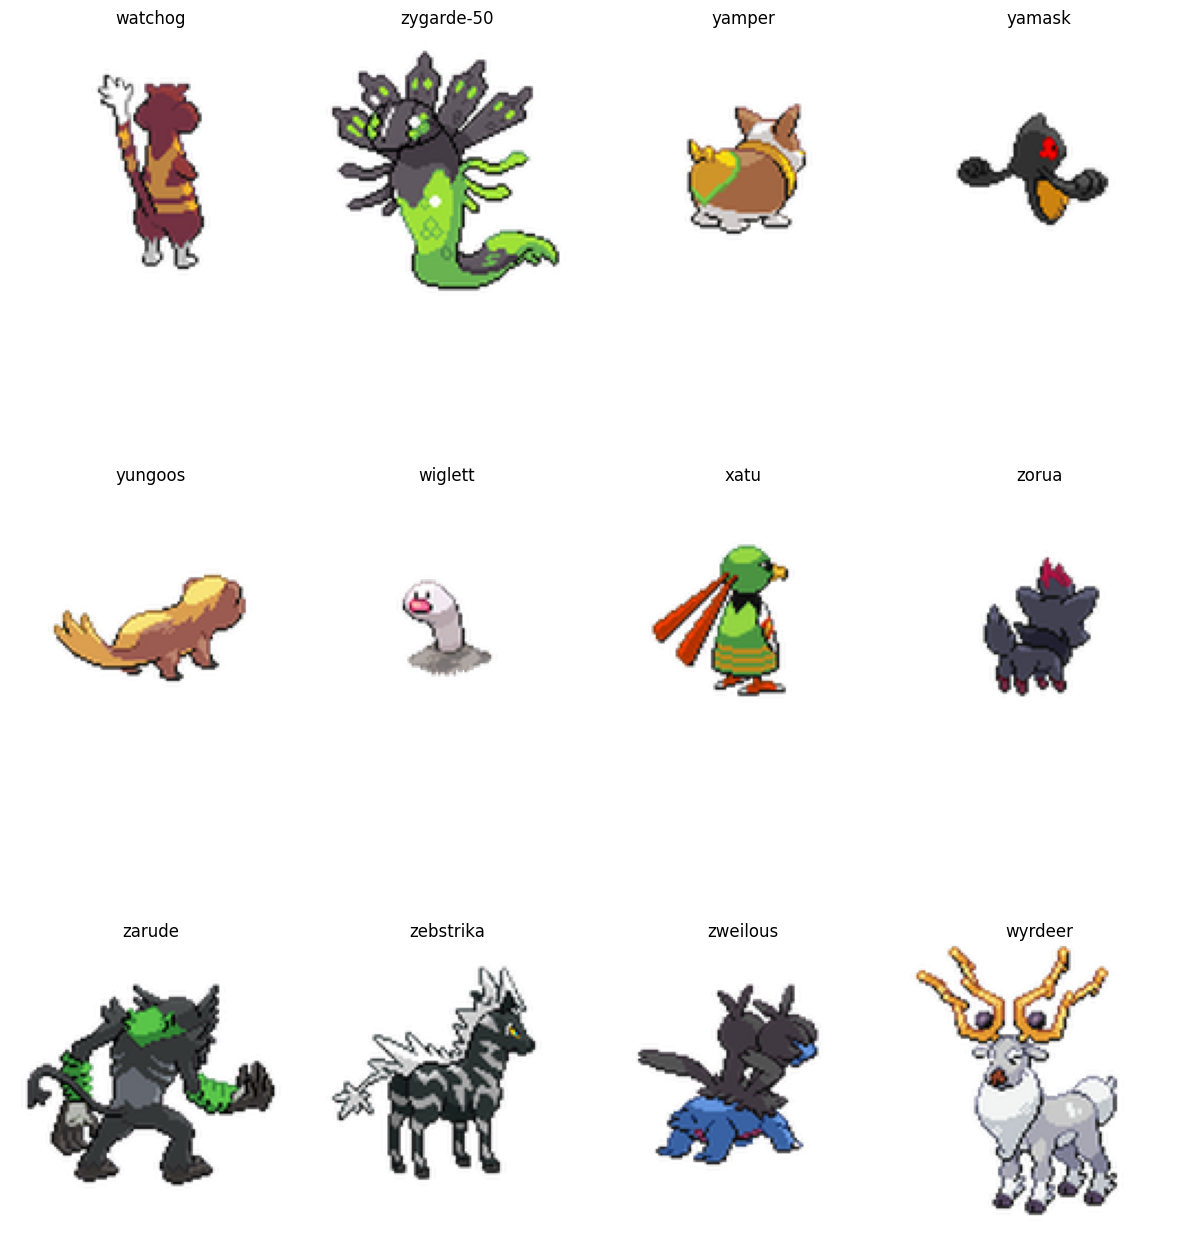

In [22]:
plt.figure(figsize=(12, 15))
for idx, label in enumerate(random_labels):
    plt.subplot(3, 4, idx + 1)
    image_path = df[df['label'] == label].iloc[0, 0]
    plt.imshow(plt.imread(image_path))
    plt.title(label)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [23]:
random_images = random.sample(list(df['path']), 1000)

image_sizes = []

for img_path in random_images:
    with Image.open(img_path) as img:
        image_sizes.append(img.size)

widths, heights = zip(*image_sizes)
average_size = (int(sum(widths) / len(widths)), int(sum(heights) / len(heights)))

print(f"Rastgele 1000 görselin ortalama boyutu: {average_size}")

Rastgele 1000 görselin ortalama boyutu: (128, 128)


In [24]:
import numpy as np
import os
from multiprocessing.pool import ThreadPool
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tqdm import tqdm  # Biblioteca para barra de progresso

# Definir caminhos para salvar os dados pré-processados
processed_images_path = "processed_images.npy"
labels_path = "labels.npy"

img_size = (128, 128)

# Verificar se os dados já foram processados anteriormente
if os.path.exists(processed_images_path) and os.path.exists(labels_path):
    print("✅ Carregando dados pré-processados...")

    # Carregar os arrays já salvos sem estourar a RAM
    X = np.memmap(processed_images_path, dtype='float32', mode='r', shape=(53078, 128, 128, 3))
    y = np.load(labels_path)

else:
    print("🚀 Processando imagens... Isso pode levar um tempo.")

    # Criar as labels codificadas (mantendo sua lógica original)
    df['label_encoded'] = df['label'].astype('category').cat.codes

    def process_image(img_path):
        """ Função para carregar e processar imagens. """
        try:
            img = load_img(img_path, target_size=img_size)
            img_array = img_to_array(img) / 255.0
            return img_array
        except Exception as e:
            print(f"Erro ao carregar {img_path}: {e}")
            return None  # Retorna None se houver erro

    # Criar numpy.memmap para armazenar as imagens no disco sem ocupar RAM
    num_images = len(df)
    X = np.memmap(processed_images_path, dtype='float32', mode='w+', shape=(num_images, img_size[0], img_size[1], 3))

    # Usar ThreadPool para leitura mais rápida
    num_workers = min(os.cpu_count(), 8)  # Definir número de threads
    images = []
    
    # Criar barra de progresso com tqdm
    with ThreadPool(num_workers) as pool:
        for i, img_array in enumerate(pool.imap(process_image, df['path']), 1):
            if img_array is not None:
                images.append(img_array)

            # Mostrar progresso a cada 40 imagens (1 classe)
            if i % 40 == 0:
                classe_atual = df.iloc[i - 1]['label']
                print(f"✅ Classe '{classe_atual}' processada!")

    # Remover imagens que falharam no carregamento
    images = [img for img in images if img is not None]

    # Converter labels para categórico
    y = to_categorical(df['label_encoded'][:len(images)])

    # Criar arquivo memmap para labels
    y_memmap = np.memmap(labels_path, dtype='float32', mode='w+', shape=y.shape)

    # Salvar imagens no arquivo memmap diretamente no disco
    print("💾 Salvando imagens no disco sem sobrecarregar a RAM...")
    for i, img in tqdm(enumerate(images), total=len(images), desc="Salvando imagens"):
        X[i] = img
    X.flush()  # Garantir que os dados sejam escritos no arquivo

    # Salvar labels no disco
    y_memmap[:] = y
    y_memmap.flush()

    print("✅ Processamento concluído! Os dados foram salvos para uso futuro.")

🚀 Processando imagens... Isso pode levar um tempo.
✅ Classe 'abomasnow' processada!
✅ Classe 'wartortle' processada!
✅ Classe 'watchog' processada!
✅ Classe 'weavile' processada!
✅ Classe 'weedle' processada!
✅ Classe 'weepinbell' processada!
✅ Classe 'weezing' processada!
✅ Classe 'whimsicott' processada!
✅ Classe 'whiscash' processada!
✅ Classe 'whismur' processada!
✅ Classe 'wigglytuff' processada!
✅ Classe 'wimpod' processada!
✅ Classe 'wingull' processada!
✅ Classe 'wobbuffet' processada!
✅ Classe 'wooloo' processada!
✅ Classe 'wooper' processada!
✅ Classe 'wormadam-plant' processada!
✅ Classe 'wurmple' processada!
✅ Classe 'wynaut' processada!
✅ Classe 'xatu' processada!
✅ Classe 'xurkitree' processada!
✅ Classe 'yanma' processada!
✅ Classe 'yanmega' processada!
✅ Classe 'yungoos' processada!
✅ Classe 'zamazenta' processada!
✅ Classe 'zangoose' processada!
✅ Classe 'zapdos' processada!
✅ Classe 'zekrom' processada!
✅ Classe 'zigzagoon' processada!
✅ Classe 'zoroark' processada!
✅

Salvando imagens: 100%|██████████| 2610/2610 [00:00<00:00, 10443.92it/s]


✅ Processamento concluído! Os dados foram salvos para uso futuro.


In [25]:
from sklearn.model_selection import train_test_split

# Garantindo que os dados sejam embaralhados corretamente
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

print(f"X Train Shape : {X_train.shape}")
print(f"X Test Shape : {X_test.shape}")
print(f"Y Train Shape : {y_train.shape}")
print(f"Y Test Shape : {y_test.shape}")


X Train Shape : (1827, 128, 128, 3)
X Test Shape : (783, 128, 128, 3)
Y Train Shape : (1827, 50)
Y Test Shape : (783, 50)


In [26]:
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)

In [27]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

In [28]:
from tensorflow.keras.applications import EfficientNetB0

# Se o arquivo estiver no Colab (pasta raiz após upload)
modelo_path = "./efficientnetb0_notop.h5"

# Se o arquivo estiver no Google Drive (use esta opção se usou a opção 2 acima)
# modelo_path = "/content/drive/MyDrive/modelos/efficientnetb0_notop.h5"

# Carregar o modelo pré-treinado com os pesos locais
base_model = EfficientNetB0(weights=modelo_path, include_top=False, input_shape=(128, 128, 3))


In [29]:
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dense(256, activation='relu', name="Layer1"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu', name="Layer2"),
    BatchNormalization(),
    Dropout(0.5),
    Dense(1000, activation='softmax', name="output_layer")
])

In [30]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [31]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [32]:
def image_generator(X, y, batch_size, class_weights):
    while True:

        for i in range(0, len(X), batch_size):
            X_batch = X[i:i + batch_size]
            y_batch = y[i:i + batch_size]


            sample_weights = np.array([class_weights.get(label, 1.0) for label in y_batch])

            yield X_batch, y_batch, sample_weights

In [33]:
print(f"Quantidade de amostras de treino: {len(X_train)}")
print(f"Quantidade de amostras de teste: {len(X_test)}")


Quantidade de amostras de treino: 1827
Quantidade de amostras de teste: 783


In [34]:
# model.add(Dropout(0.5))
# from tensorflow.keras.regularizers import l2
# model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))

In [37]:
history = model.fit(
    image_generator(X_train, y_train, batch_size=256, class_weights=class_weights_dict),
    steps_per_epoch=len(X_train) // 256,
    epochs=2,
    validation_data=image_generator(X_test, y_test, batch_size=256, class_weights=class_weights_dict),
    validation_steps=len(X_test) // 256,
    callbacks=[early_stopping] 
)


Epoch 1/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 101s 15s/step - accuracy: 0.9430 - loss: 1.8412 - val_accuracy: 0.0117 - val_loss: 6.6650
Epoch 2/2
7/7 ━━━━━━━━━━━━━━━━━━━━ 89s 15s/step - accuracy: 0.9679 - loss: 1.4506 - val_accuracy: 0.0143 - val_loss: 6.4953


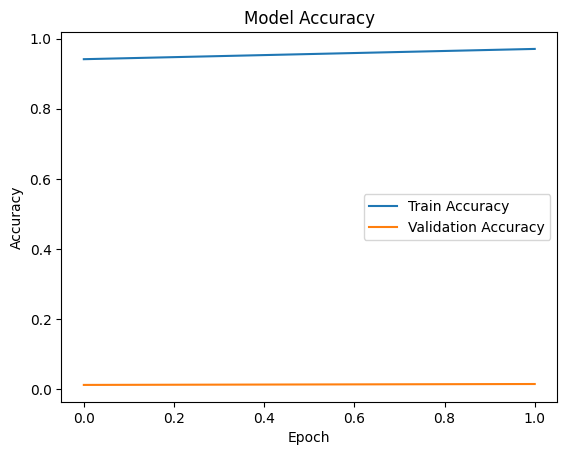

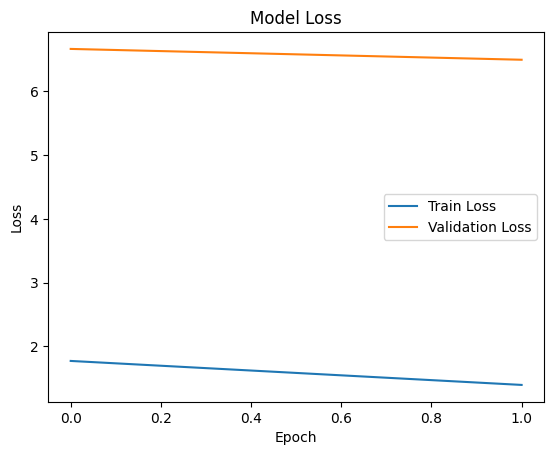

In [38]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
results = model.evaluate(X_test, y_test)
test_loss, test_accuracy = results[0], results[1]
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 9s 248ms/step - accuracy: 0.0145 - loss: 6.2949
Test Loss: 6.5580
Test Accuracy: 0.0102


In [ ]:
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted Average F1 Score: {f1_weighted:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 10s 312ms/step
Weighted Average F1 Score: 0.0002


In [ ]:
import numpy as np

overlap = np.intersect1d(X_train, X_test, assume_unique=True)
print(f"Número de amostras duplicadas entre treino e teste: {len(overlap)}")


Número de amostras duplicadas entre treino e teste: 128286464


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


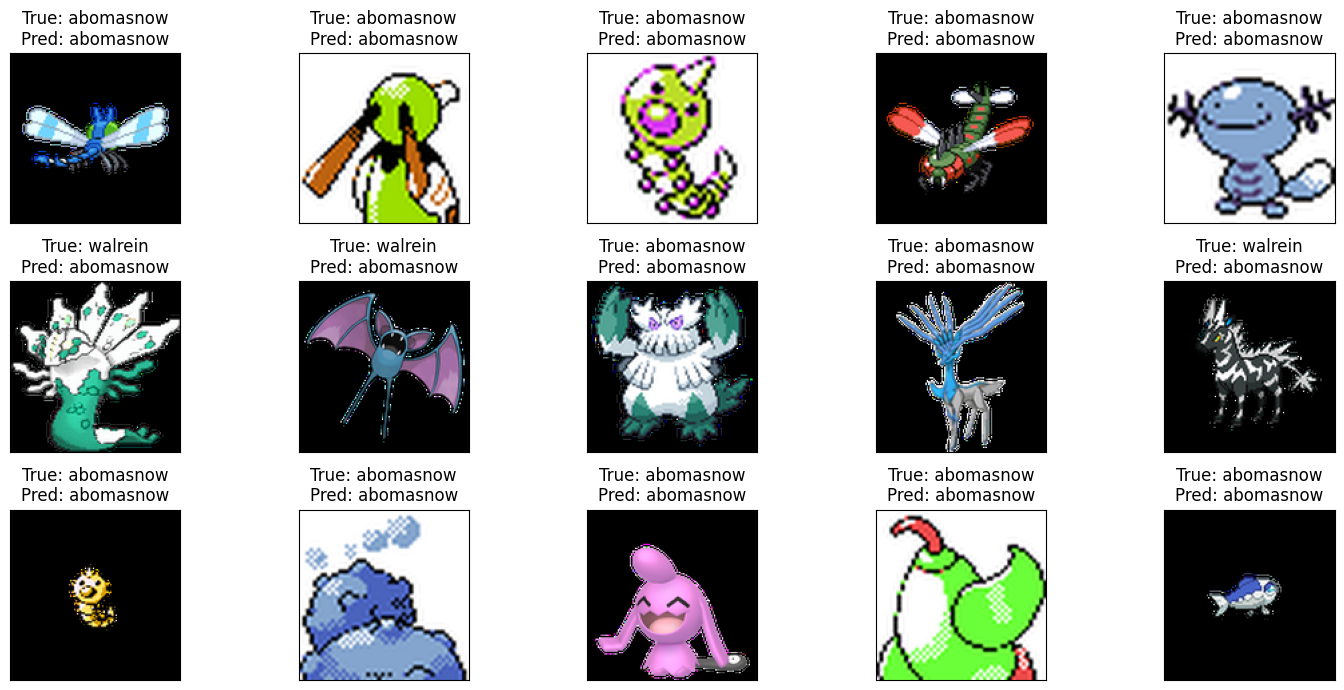

In [39]:
num_images = 15
indices = np.random.choice(len(X_test), num_images, replace=False)
selected_images = X_test[indices]
true_labels = y_test[indices]
predicted_labels = np.argmax(model.predict(selected_images), axis=1)


pokemon_names = df["label"].values

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img = selected_images[i]
    if img.shape[-1] == 1:
        img = img.squeeze(-1)
    ax.imshow(img, cmap='gray' if img.ndim == 2 else None)

    true_pokemon = pokemon_names[true_labels[i]]
    predicted_pokemon = pokemon_names[predicted_labels[i]]
    ax.set_title(f"True: {true_pokemon}\nPred: {predicted_pokemon}")

plt.tight_layout()
plt.show()